
Missing values before cleaning:
Month                                                       0
Day                                                         0
Time                                                        0
Date                                                        0
Total Calls                                               819
Connected Calls                                           819
Calls Not Connected                                       819
Calls Not Connected (Length Limit Reached)                819
Calls Not Connected (Contact Hung Up)                     819
Calls Not Connected (Caller Hangup Within 5 Seconds)      819
Calls Not Connected (Caller Hangup Within 10 Seconds)     819
Calls Not Connected (Caller Hangup Within 20 Seconds)     819
Availability (%)                                          819
TOTAL CALLS INCLUDING HANGUPS (M)                         819
Avg Call Length (s)                                       819
Longest Wait Time (s)                

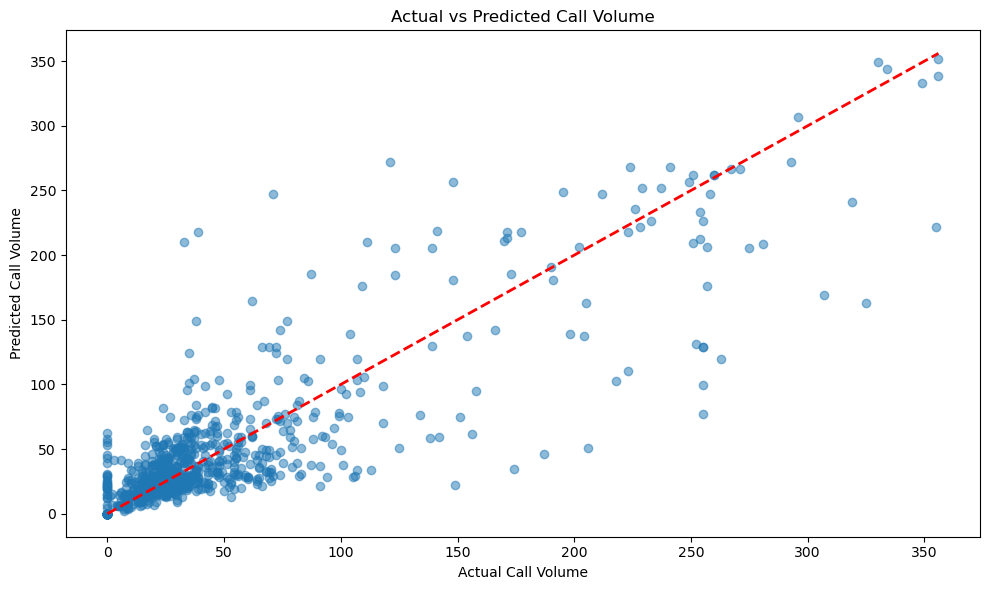


Example Predictions:
Monday 9:00 AM in April: 99.31533333333333
Wednesday 2:30 PM in July: 18.476751443001444


In [5]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Load the data
df = pd.read_csv('2024-25 PMP Telephony Dashboard(2024-25 Raw Data (2)).csv')

# Create datetime and extract features
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], 
                              format='%d/%m/%Y %H:%M',
                              dayfirst=True)

# Create features
df['Hour'] = df['DateTime'].dt.hour
df['Minute'] = df['DateTime'].dt.minute
df['DayOfWeek'] = df['DateTime'].dt.dayofweek  # Monday=0, Sunday=6
df['Month'] = df['DateTime'].dt.month
df['IsMonday'] = (df['DayOfWeek'] == 0).astype(int)
df['IsMorning'] = (df['Hour'] < 12).astype(int)
df['TimeSlot'] = df['Hour'] + df['Minute']/60

# Check for NaN values
print("\nMissing values before cleaning:")
print(df.isnull().sum())

# Clean the data
# 1. Remove rows with NaN values
df = df.dropna(subset=['Total Calls'])

# 2. Or alternatively, fill NaN values with mean/median
# df['Total Calls'] = df['Total Calls'].fillna(df['Total Calls'].mean())

print("\nMissing values after cleaning:")
print(df.isnull().sum())

# Prepare features and target
X = df[['Hour', 'Minute', 'DayOfWeek', 'Month', 'IsMonday', 'IsMorning', 'TimeSlot']]
y = df['Total Calls']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("\nModel Performance:")
print("R² Score:", r2_score(y_test, y_pred))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Visualization of actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Call Volume')
plt.ylabel('Predicted Call Volume')
plt.title('Actual vs Predicted Call Volume')
plt.tight_layout()
plt.show()

# Function to predict call volume for a specific time
def predict_call_volume(hour, minute, day_of_week, month):
    """
    Predict call volume for a specific time
    hour: 0-23
    minute: 0 or 30
    day_of_week: 0-6 (Monday=0)
    month: 1-12
    """
    features = pd.DataFrame({
        'Hour': [hour],
        'Minute': [minute],
        'DayOfWeek': [day_of_week],
        'Month': [month],
        'IsMonday': [1 if day_of_week == 0 else 0],
        'IsMorning': [1 if hour < 12 else 0],
        'TimeSlot': [hour + minute/60]
    })
    
    return rf_model.predict(features)[0]

# Example usage
print("\nExample Predictions:")
print("Monday 9:00 AM in April:", 
      predict_call_volume(hour=9, minute=0, day_of_week=0, month=4))
print("Wednesday 2:30 PM in July:", 
      predict_call_volume(hour=14, minute=30, day_of_week=2, month=7))

### Simple regression tree

Here we are trying a simple regression tree to predict what a call volume is on any given day.  

/Users/clexp/Sync/hsma/anaconda3/envs/bap3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/clexp/Sync/hsma/anaconda3/envs/bap3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/clexp/Sync/hsma/anaconda3/envs/bap3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/

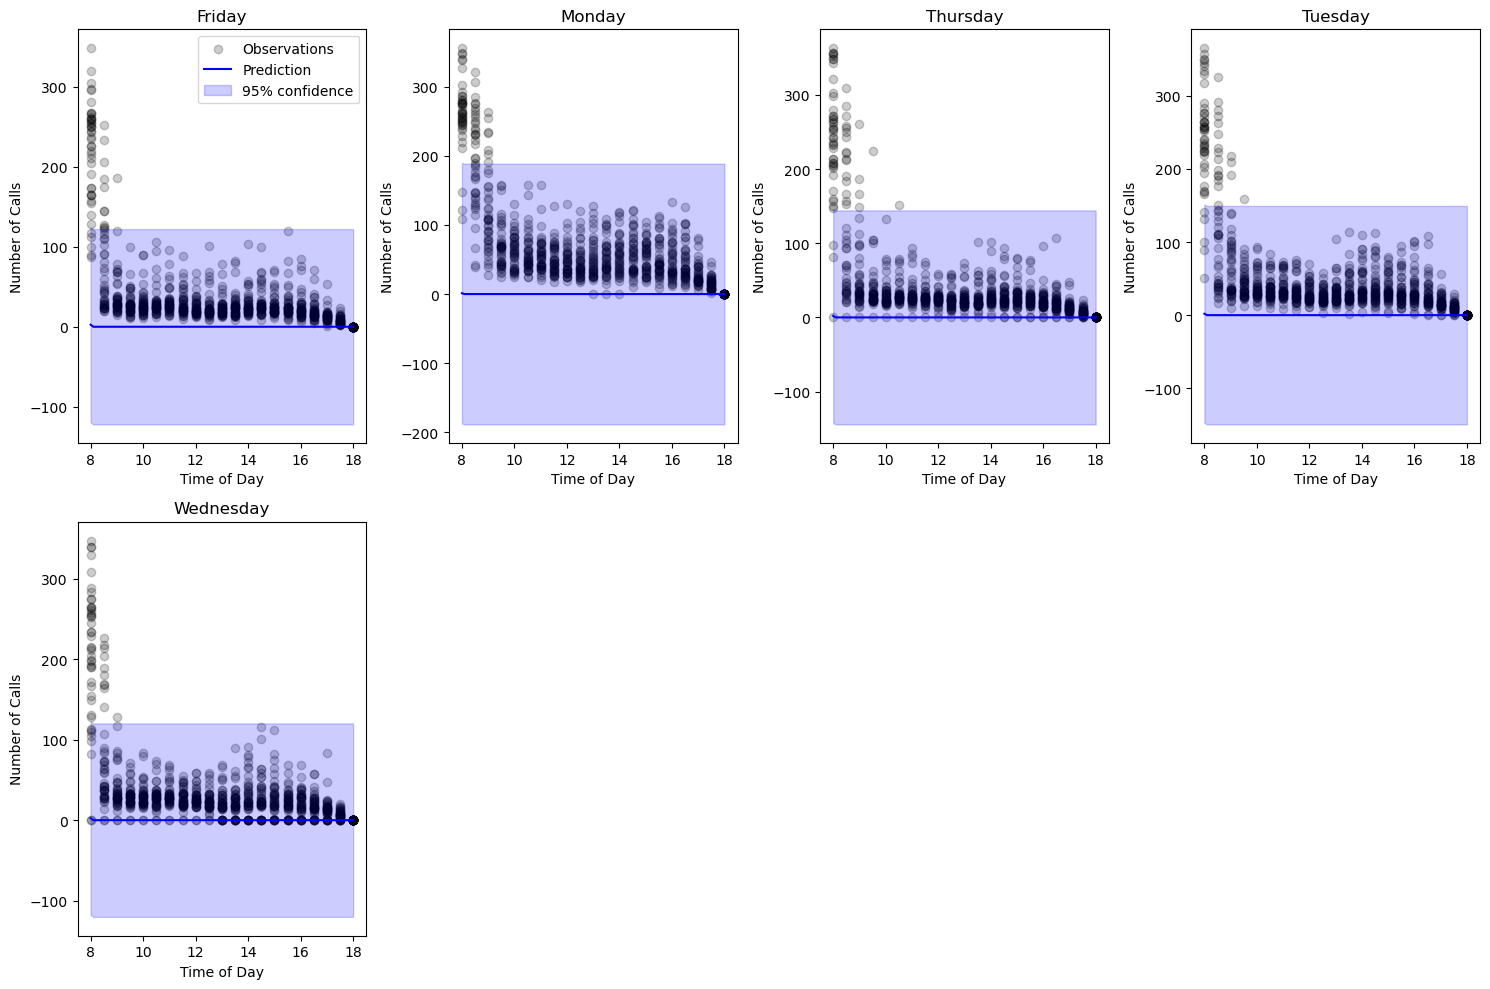


Example Predictions:

Monday 09:00
Predicted calls: 1
Standard deviation: 94
95% Confidence Interval: (-188, 189)

Wednesday 14:30
Predicted calls: 0
Standard deviation: 60
95% Confidence Interval: (-120, 120)

Friday 16:00
Predicted calls: 0
Standard deviation: 61
95% Confidence Interval: (-122, 122)

Summary Statistics by Weekday:
                mean        std  min    max
Weekday                                    
Friday     36.788961  49.409074  0.0  348.0
Monday     68.318235  65.628100  0.0  356.0
Thursday   41.314935  59.714156  0.0  363.0
Tuesday    47.118519  58.581093  0.0  365.0
Wednesday  34.769481  49.667147  0.0  347.0


In [6]:




from datetime import datetime, timedelta
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# Load the data
df = pd.read_csv('2024-25 PMP Telephony Dashboard(2024-25 Raw Data (2)).csv')

# Create datetime and extract features
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], 
                              format='%d/%m/%Y %H:%M',
                              dayfirst=True)

# Create features
df['TimeSlot'] = df['DateTime'].dt.hour + df['DateTime'].dt.minute/60
df['Weekday'] = df['DateTime'].dt.day_name()

# Clean any NaN values
df = df.dropna(subset=['Total Calls'])

# Create a Gaussian Process model for each weekday
weekday_models = {}
scaler = StandardScaler()

plt.figure(figsize=(15, 10))

for day in sorted(df['Weekday'].unique()):
    day_data = df[df['Weekday'] == day]
    
    # Prepare data
    X = day_data[['TimeSlot']].values
    y = day_data['Total Calls'].values
    
    # Scale the data
    X_scaled = scaler.fit_transform(X)
    
    # Define and fit the Gaussian Process
    kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0)
    gp = GaussianProcessRegressor(kernel=kernel, random_state=42)
    gp.fit(X_scaled, y)
    
    # Store the model and scaler
    weekday_models[day] = {
        'model': gp,
        'scaler': scaler
    }
    
    # Make predictions across the day
    X_pred = np.linspace(8, 18, 100).reshape(-1, 1)  # 8am to 6pm
    X_pred_scaled = scaler.transform(X_pred)
    y_pred, sigma = gp.predict(X_pred_scaled, return_std=True)
    
    # Plot
    plt.subplot(2, 4, list(sorted(df['Weekday'].unique())).index(day) + 1)
    plt.scatter(X, y, c='black', alpha=0.2, label='Observations')
    plt.plot(X_pred, y_pred, 'b-', label='Prediction')
    plt.fill_between(X_pred.ravel(), 
                    y_pred - 2*sigma, 
                    y_pred + 2*sigma, 
                    color='b', 
                    alpha=0.2,
                    label='95% confidence')
    plt.title(day)
    plt.xlabel('Time of Day')
    plt.ylabel('Number of Calls')
    if day == sorted(df['Weekday'].unique())[0]:  # Only show legend for first plot
        plt.legend()

plt.tight_layout()
plt.show()

# Function to predict call volume with uncertainty
def predict_call_volume(weekday, hour, minute):
    if weekday not in weekday_models:
        return None
    
    time_slot = hour + minute/60
    model_info = weekday_models[weekday]
    
    # Scale input
    X_pred = np.array([[time_slot]])
    X_pred_scaled = model_info['scaler'].transform(X_pred)
    
    # Make prediction
    mean, std = model_info['model'].predict(X_pred_scaled, return_std=True)
    
    return {
        'mean': mean[0],
        'std': std[0],
        'confidence_interval': (mean[0] - 2*std[0], mean[0] + 2*std[0])
    }

# Example predictions
print("\nExample Predictions:")
times_to_check = [
    ('Monday', 9, 0),  # Monday 9:00 AM
    ('Wednesday', 14, 30),  # Wednesday 2:30 PM
    ('Friday', 16, 0)  # Friday 4:00 PM
]

for day, hour, minute in times_to_check:
    prediction = predict_call_volume(day, hour, minute)
    if prediction:
        print(f"\n{day} {hour:02d}:{minute:02d}")
        print(f"Predicted calls: {prediction['mean']:.0f}")
        print(f"Standard deviation: {prediction['std']:.0f}")
        print(f"95% Confidence Interval: ({prediction['confidence_interval'][0]:.0f}, "
              f"{prediction['confidence_interval'][1]:.0f})")

# Summary statistics
print("\nSummary Statistics by Weekday:")
summary_stats = df.groupby('Weekday')['Total Calls'].agg(['mean', 'std', 'min', 'max'])
print(summary_stats)


### This is a Gaian regression based analysis and requires carefully interpretation

In this situation the cool volumes per half hour per day have been mapped to a Galian process to determine the mean and standard deviation. This has been mapped by one graph per day with time on the X axis. If this is correct, it also reveals some interesting insights that Thursday is the most variable day and while higher Monday as the least variability.

The summary statistics need some confirmation as to their applicability and accuracy

/Users/clexp/Sync/hsma/anaconda3/envs/bap3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/clexp/Sync/hsma/anaconda3/envs/bap3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/clexp/Sync/hsma/anaconda3/envs/bap3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/

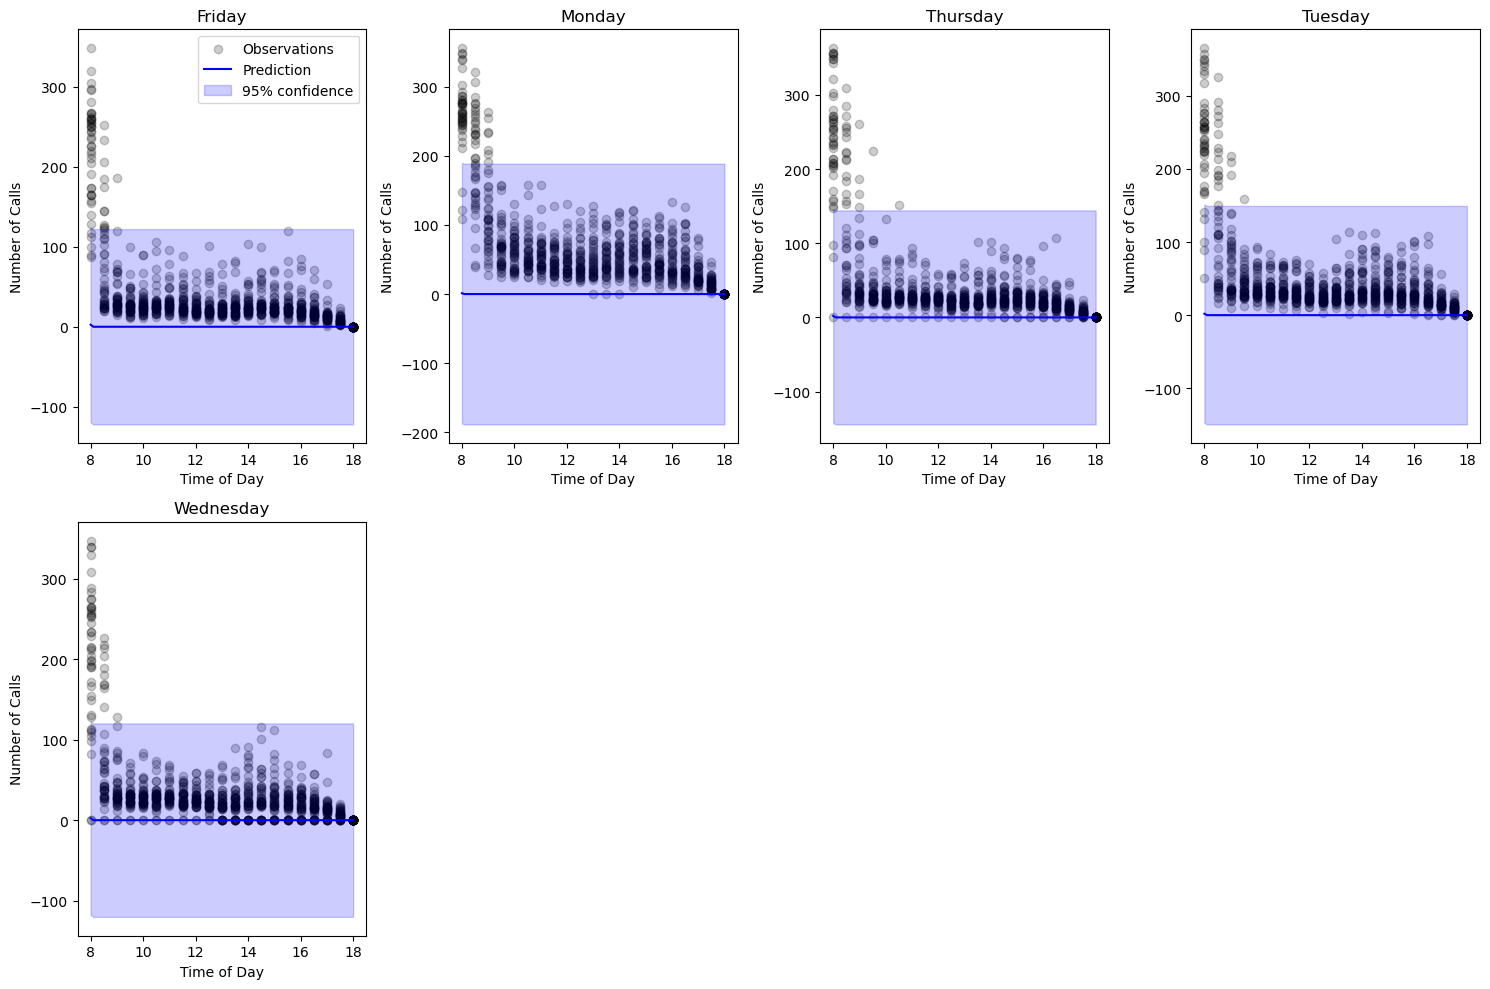


Example Predictions:

Monday 09:00
Predicted calls: 1
Standard deviation: 94
95% Confidence Interval: (-188, 189)

Wednesday 14:30
Predicted calls: 0
Standard deviation: 60
95% Confidence Interval: (-120, 120)

Friday 16:00
Predicted calls: 0
Standard deviation: 61
95% Confidence Interval: (-122, 122)

Summary Statistics by Weekday:
                mean        std  min    max
Weekday                                    
Friday     36.788961  49.409074  0.0  348.0
Monday     68.318235  65.628100  0.0  356.0
Thursday   41.314935  59.714156  0.0  363.0
Tuesday    47.118519  58.581093  0.0  365.0
Wednesday  34.769481  49.667147  0.0  347.0


In [13]:

from datetime import datetime, timedelta
from sklearn.gaussian_process import GaussianProcessRegressor

# Load the data
df = pd.read_csv('2024-25 PMP Telephony Dashboard(2024-25 Raw Data (2)).csv')

# Create datetime and extract features
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], 
                              format='%d/%m/%Y %H:%M',
                              dayfirst=True)

# Create features
df['TimeSlot'] = df['DateTime'].dt.hour + df['DateTime'].dt.minute/60
df['Weekday'] = df['DateTime'].dt.day_name()

# Clean any NaN values
df = df.dropna(subset=['Total Calls'])

# Create a Gaussian Process model for each weekday
weekday_models = {}
scaler = StandardScaler()

plt.figure(figsize=(15, 10))

for day in sorted(df['Weekday'].unique()):
    day_data = df[df['Weekday'] == day]
    
    # Prepare data
    X = day_data[['TimeSlot']].values
    y = day_data['Total Calls'].values
    
    # Scale the data
    X_scaled = scaler.fit_transform(X)
    
    # Define and fit the Gaussian Process
    kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0)
    gp = GaussianProcessRegressor(kernel=kernel, random_state=42)
    gp.fit(X_scaled, y)
    
    # Store the model and scaler
    weekday_models[day] = {
        'model': gp,
        'scaler': scaler
    }
    
    # Make predictions across the day
    X_pred = np.linspace(8, 18, 100).reshape(-1, 1)  # 8am to 6pm
    X_pred_scaled = scaler.transform(X_pred)
    y_pred, sigma = gp.predict(X_pred_scaled, return_std=True)
    
    # Plot
    plt.subplot(2, 4, list(sorted(df['Weekday'].unique())).index(day) + 1)
    plt.scatter(X, y, c='black', alpha=0.2, label='Observations')
    plt.plot(X_pred, y_pred, 'b-', label='Prediction')
    plt.fill_between(X_pred.ravel(), 
                    y_pred - 2*sigma, 
                    y_pred + 2*sigma, 
                    color='b', 
                    alpha=0.2,
                    label='95% confidence')
    plt.title(day)
    plt.xlabel('Time of Day')
    plt.ylabel('Number of Calls')
    if day == sorted(df['Weekday'].unique())[0]:  # Only show legend for first plot
        plt.legend()

plt.tight_layout()
plt.show()

# Function to predict call volume with uncertainty
def predict_call_volume(weekday, hour, minute):
    if weekday not in weekday_models:
        return None
    
    time_slot = hour + minute/60
    model_info = weekday_models[weekday]
    
    # Scale input
    X_pred = np.array([[time_slot]])
    X_pred_scaled = model_info['scaler'].transform(X_pred)
    
    # Make prediction
    mean, std = model_info['model'].predict(X_pred_scaled, return_std=True)
    
    return {
        'mean': mean[0],
        'std': std[0],
        'confidence_interval': (mean[0] - 2*std[0], mean[0] + 2*std[0])
    }

# Example predictions
print("\nExample Predictions:")
times_to_check = [
    ('Monday', 9, 0),  # Monday 9:00 AM
    ('Wednesday', 14, 30),  # Wednesday 2:30 PM
    ('Friday', 16, 0)  # Friday 4:00 PM
]

for day, hour, minute in times_to_check:
    prediction = predict_call_volume(day, hour, minute)
    if prediction:
        print(f"\n{day} {hour:02d}:{minute:02d}")
        print(f"Predicted calls: {prediction['mean']:.0f}")
        print(f"Standard deviation: {prediction['std']:.0f}")
        print(f"95% Confidence Interval: ({prediction['confidence_interval'][0]:.0f}, "
              f"{prediction['confidence_interval'][1]:.0f})")

# Summary statistics
print("\nSummary Statistics by Weekday:")
summary_stats = df.groupby('Weekday')['Total Calls'].agg(['mean', 'std', 'min', 'max'])
print(summary_stats)

### Inappropriate use of modelling tools

In this situation, we have tried to use Basin analysis to arrive at the mean and variance for each weekday for each half hour. We have a series of observations that are scattered on the graph. The confidence interval has been drawn around zero or one as a main. This is incorrect. This seems a normal distribution which it is not. This is a log normal or press on distribution for any given half hour slot for any given day.

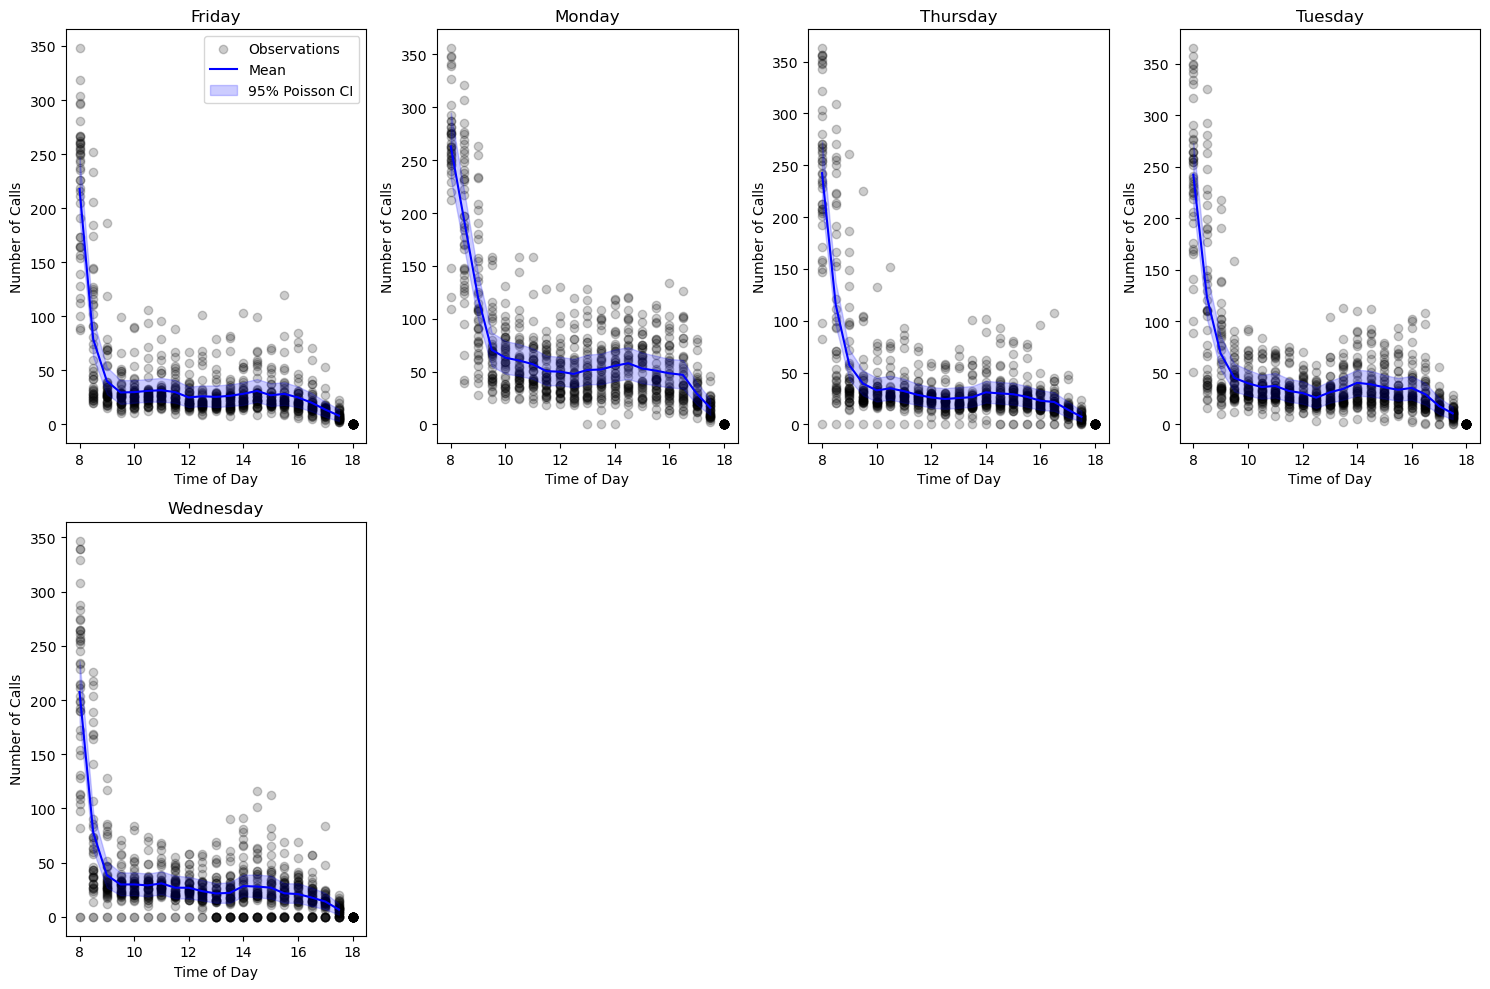


Detailed analysis for Monday 09:00
Number of observations: 41
Mean: 119.85
Variance: 3765.28
Min: 28.0
Max: 263.0


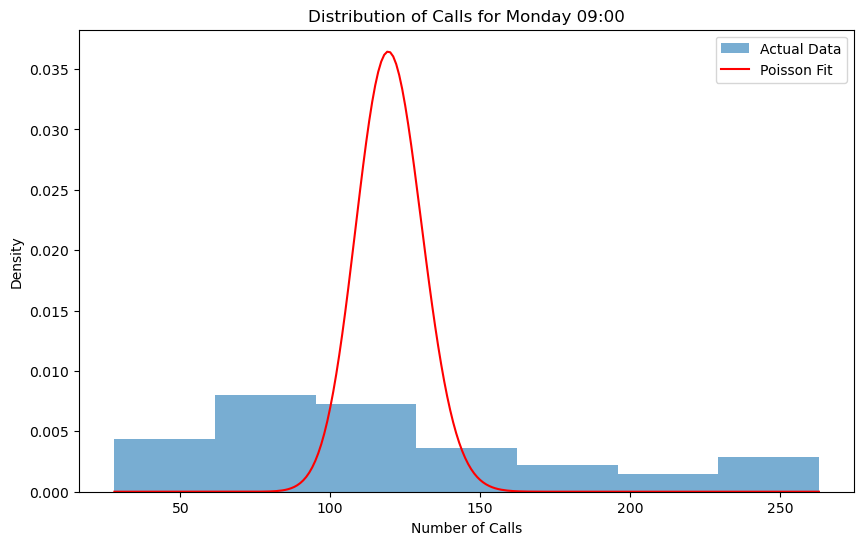

In [14]:

from scipy import stats

# Load the data
df = pd.read_csv('2024-25 PMP Telephony Dashboard(2024-25 Raw Data (2)).csv')

# Create datetime and extract features
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], 
                              format='%d/%m/%Y %H:%M',
                              dayfirst=True)

df['TimeSlot'] = df['DateTime'].dt.hour + df['DateTime'].dt.minute/60
df['Weekday'] = df['DateTime'].dt.day_name()

# Clean data - remove any NaN or negative values
df = df.dropna(subset=['Total Calls'])
df = df[df['Total Calls'] >= 0]

plt.figure(figsize=(15, 10))

for day in sorted(df['Weekday'].unique()):
    day_data = df[df['Weekday'] == day]
    
    plt.subplot(2, 4, list(sorted(df['Weekday'].unique())).index(day) + 1)
    time_slots = sorted(day_data['TimeSlot'].unique())
    
    means = []
    ci_lower = []
    ci_upper = []
    
    for slot in time_slots:
        slot_data = day_data[day_data['TimeSlot'] == slot]['Total Calls']
        
        # Calculate mean and ensure it's valid
        mean = float(slot_data.mean())
        if np.isnan(mean) or mean <= 0:
            print(f"Warning: Invalid mean ({mean}) for {day} at time {slot}")
            continue
            
        try:
            # Calculate Poisson confidence interval with corrected parameter name
            ci = stats.poisson.interval(confidence=0.95, mu=mean)
            means.append(mean)
            ci_lower.append(ci[0])
            ci_upper.append(ci[1])
        except Exception as e:
            print(f"Error calculating CI for {day} at time {slot}: {e}")
            print(f"Mean value was: {mean}")
            continue
    
    # Plot actual observations
    plt.scatter(day_data['TimeSlot'], day_data['Total Calls'], 
               c='black', alpha=0.2, label='Observations')
    
    # Only plot means and CIs if we have valid data
    if means:
        plt.plot(time_slots[:len(means)], means, 'b-', label='Mean')
        plt.fill_between(time_slots[:len(means)], ci_lower, ci_upper,
                        color='b', alpha=0.2,
                        label='95% Poisson CI')
    
    plt.title(day)
    plt.xlabel('Time of Day')
    plt.ylabel('Number of Calls')
    if day == sorted(df['Weekday'].unique())[0]:
        plt.legend()

plt.tight_layout()
plt.show()

# Examine one time slot in detail
example_slot = ('Monday', 9.0)
slot_data = df[(df['Weekday'] == example_slot[0]) & 
               (df['TimeSlot'] == example_slot[1])]['Total Calls']

print(f"\nDetailed analysis for {example_slot[0]} {example_slot[1]:02.0f}:00")
print(f"Number of observations: {len(slot_data)}")
print(f"Mean: {slot_data.mean():.2f}")
print(f"Variance: {slot_data.var():.2f}")
print(f"Min: {slot_data.min()}")
print(f"Max: {slot_data.max()}")

# Plot distribution for this time slot
plt.figure(figsize=(10, 6))
plt.hist(slot_data, bins='auto', density=True, alpha=0.6, label='Actual Data')
mean = slot_data.mean()
x = np.arange(int(slot_data.min()), int(slot_data.max()) + 1)
poisson_pmf = stats.poisson.pmf(x, mean)
plt.plot(x, poisson_pmf, 'r-', label='Poisson Fit')
plt.title(f'Distribution of Calls for {example_slot[0]} {example_slot[1]:02.0f}:00')
plt.xlabel('Number of Calls')
plt.ylabel('Density')
plt.legend()
plt.show()

### More appropriate use of tools

In the first set of graphs We have a graph each day plotting all the data points by half hourly section. Overlay this we have the mean for that half hour plus the confidence interval of 95% either side of the main. This was derived by Bayesian method.

This tells us even with the wide distribution of data we have we can confidently predict with 95% accuracy that we will have a given cool volume in ebony given half hour slot across any given day of the week. It remains to be seen what extracting pre-and post bank holiday days may do.

In a second graph, we have a probability density function graph with the press on mean at standard deviation for 9 am on a Monday. It is interesting to see that even though the actual data provides quite abroad distribution the derived main and standard deviation on the press on distribution is relatively tight.